# Fake or real? Using AI to detect whether images are real or generated by AI.


## 1. Use thispersondoesnotexist.com

In [1]:
import requests
import os
from datetime import datetime

def download_ai_face():
    # URL of the AI-generated face
    url = "https://thispersondoesnotexist.com"
    
    # Create images directory if it doesn't exist
    if not os.path.exists('images'):
        os.makedirs('images')
    
    try:
        # Get the image
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        # Generate unique filename with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"images/tpdne_person_{timestamp}.jpg"
        
        # Save the image
        with open(filename, 'wb') as f:
            f.write(response.content)
        
        print(f"Image downloaded successfully as {filename}")
        return filename
    
    except requests.RequestException as e:
        print(f"Error downloading image: {e}")
        return None

# Call the function
generated_image = download_ai_face()

Image downloaded successfully as images/tpdne_person_20250613_132846.jpg


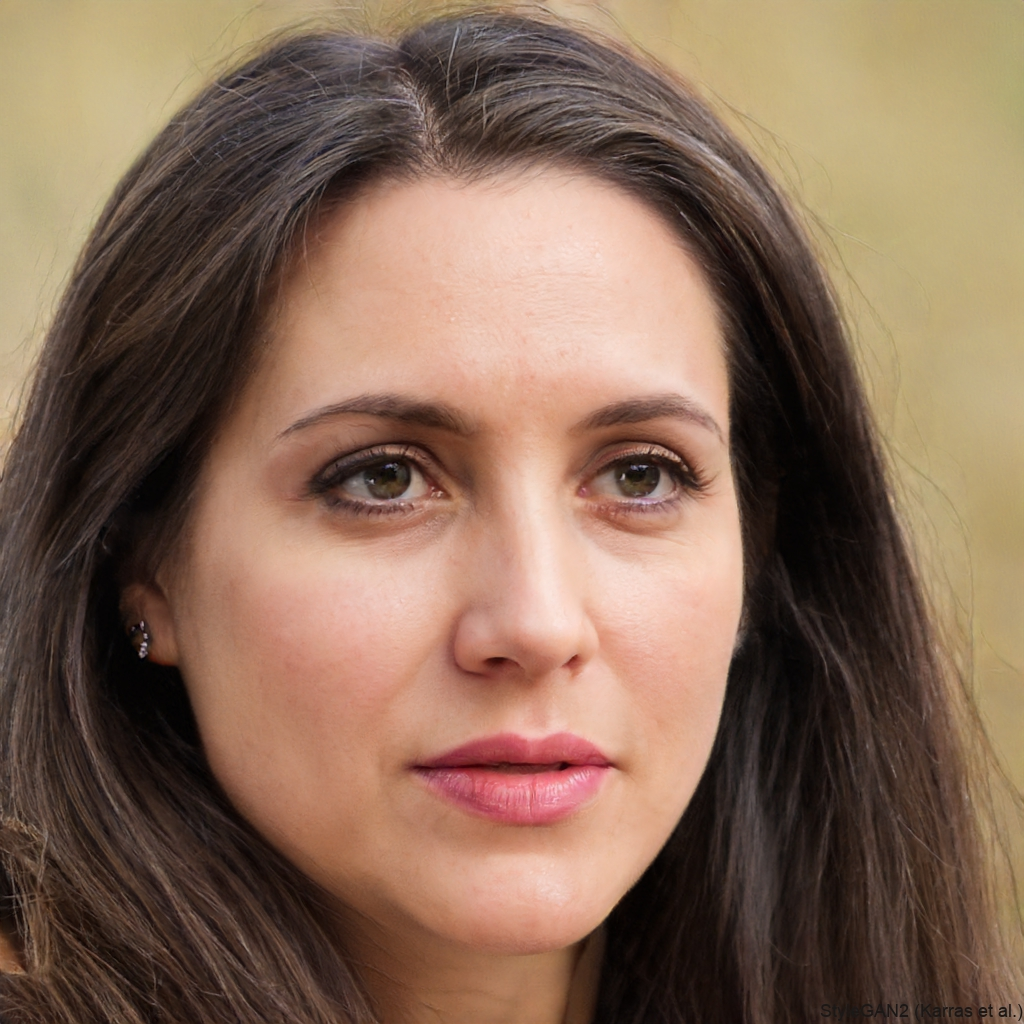

In [2]:
import IPython
import IPython.display
IPython.display.Image(filename=generated_image, width=300) 

Cropped image saved as images/tpdne_person_20250613_132846_cropped.jpg


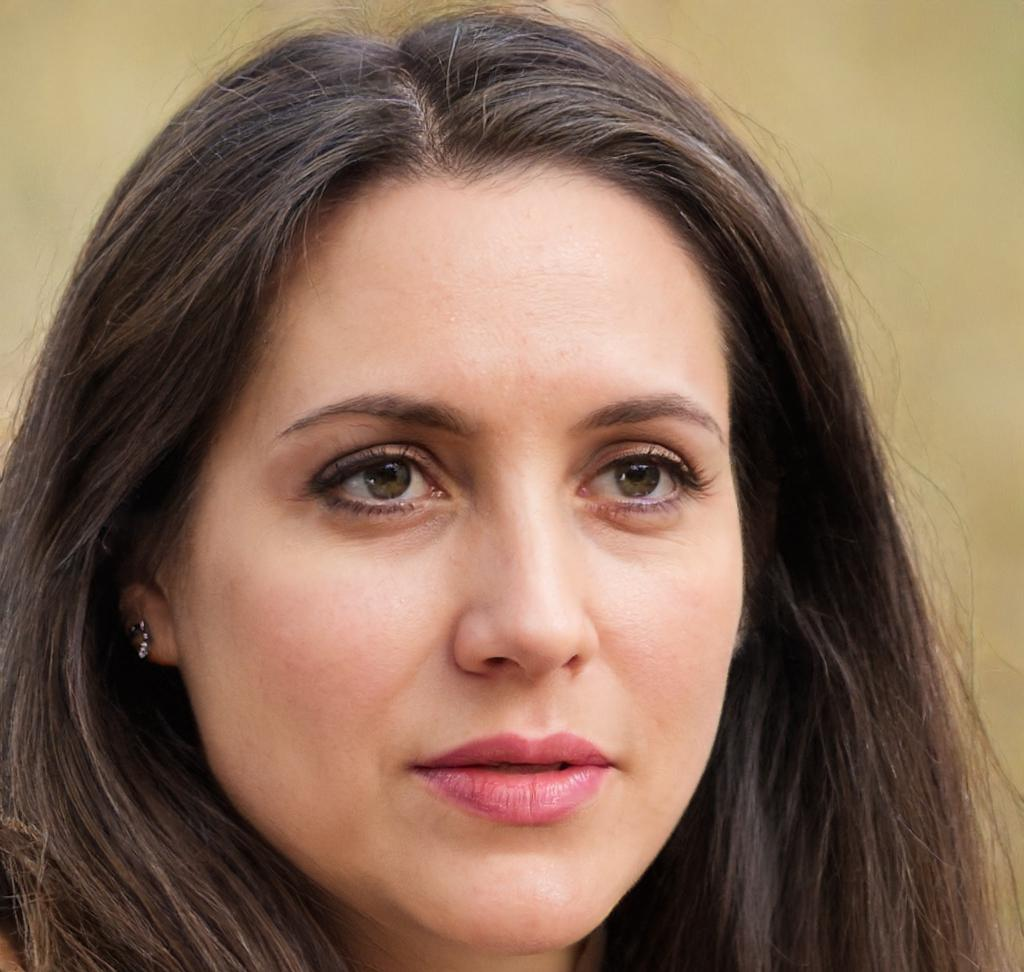

In [3]:
from PIL import Image

image_path = generated_image

def crop_bottom(image_path):
    # Open the image
    img = Image.open(image_path)
    
    # Get dimensions
    width, height = img.size
    
    # Calculate new height (95% of original)
    new_height = int(height * 0.95)
    
    # Crop the image
    cropped_img = img.crop((0, 0, width, new_height))
    
    # Generate output filename
    output_path = image_path.replace('.jpg', '_cropped.jpg')
    
    # Save the cropped image
    cropped_img.save(output_path)
    print(f"Cropped image saved as {output_path}")
    return output_path

# Crop the selected image
cropped_image = crop_bottom(image_path)

# Display the cropped image
IPython.display.Image(cropped_image, width=300)

## 2. Upload an image

In [82]:
import glob
image_list = glob.glob('./images/*.jpeg')
image_list

['./images/zelensky_card.jpeg',
 './images/person_flux_3.jpeg',
 './images/person_flux_4.jpeg']

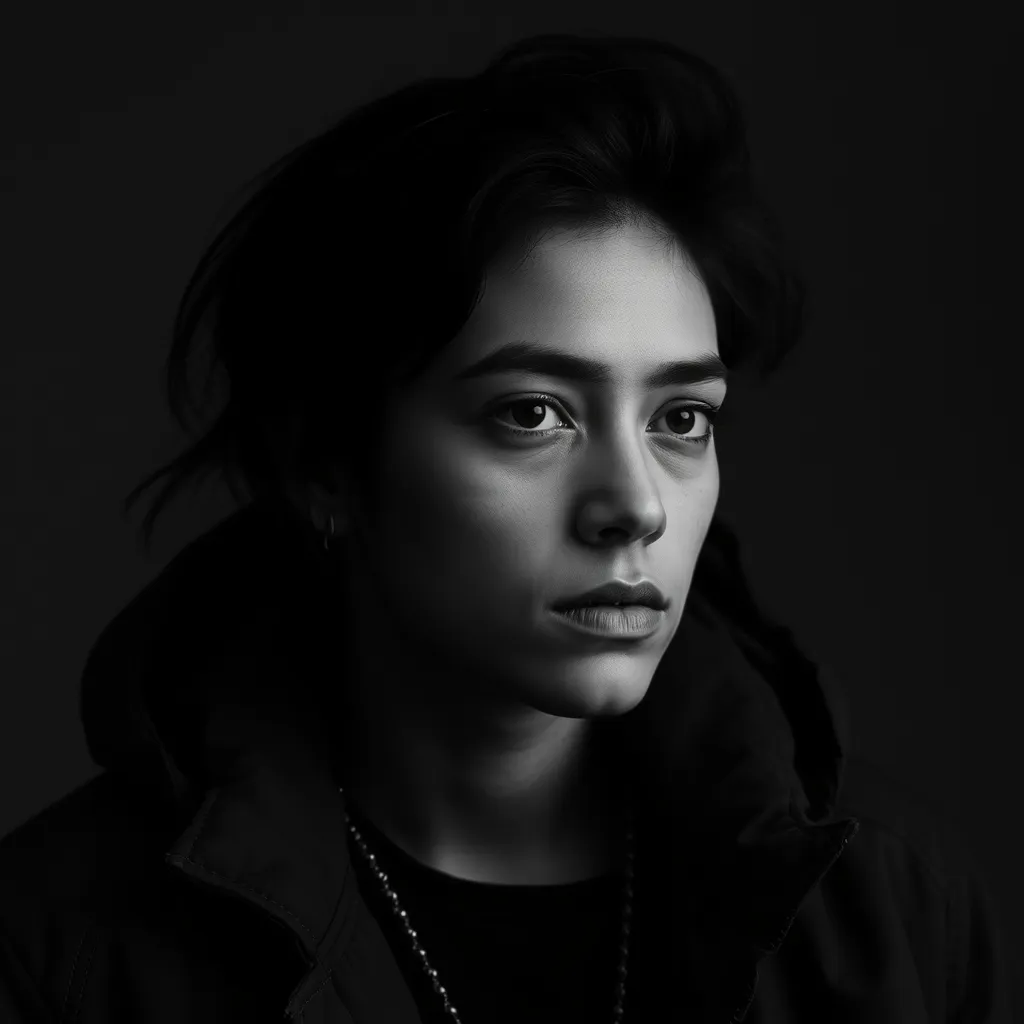

In [83]:
cropped_image= image_list[2]

import IPython
IPython.display.Image(cropped_image, width=300)

## 3. Call the (reasoning) model - Claude 4

In [4]:
#Initialize the Anthropic API client

import anthropic
import config

client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key=config.ANTHROPIC_API_KEY,
)


In [5]:
import base64
from PIL import Image
import io

# Convert image to JPEG and encode
img = Image.open(cropped_image)
img_byte_arr = io.BytesIO()
img.save(img_byte_arr, format='JPEG')
img_byte_arr = img_byte_arr.getvalue()
image_data = base64.b64encode(img_byte_arr).decode()


# Read and encode image
#with open(cropped_image, "rb") as f:
#    image_data = base64.b64encode(f.read()).decode()

# Call API
response = client.messages.create(
    model="claude-4-sonnet-20250514",
    max_tokens=1000,
    messages=[{
        "role": "user",
        "content": [
            {
                "type": "image",
                "source": {
                    "type": "base64",
                    "media_type": "image/jpeg",
                    "data": image_data
                }
            },
            {"type": "text", "text": "Give me five arguments why this image is ai generated and give me five arguments why this image is real. Keep your arguments short and to the point. Then give me a final conclusion."}
        ]
    }]
)

IPython.display.Image(cropped_image, width=300)  # Display the cropped image
print(response.content[0].text)

**Five arguments this image is AI-generated:**
1. The skin appears unnaturally smooth and perfect with no visible pores or texture
2. The lighting seems too even and flawless across the entire face
3. The hair strands look somewhat artificial and lack natural randomness
4. The eyes have an overly perfect, glossy appearance typical of AI rendering
5. The overall composition seems too "perfect" without natural asymmetries

**Five arguments this image is real:**
1. The earring shows realistic light reflection and shadows
2. There are subtle imperfections like slight under-eye circles visible
3. The hair shows natural variations in color and individual strand detail
4. The lip texture appears realistic with natural lip lines
5. The background has a natural, slightly blurred quality typical of portrait photography

**Final conclusion:**
This appears to be a **real photograph** of an actual person. While the image quality is high and the subject is photogenic, the natural imperfections, real

In [64]:
# Split and filter out empty lines
argument_list = [line for line in response.content[0].text.split("\n") if line.strip()]
# Get the arguments (adjust indices if needed based on filtered content)
filtered_arguments = [arg for arg in argument_list if arg]
filtered_arguments

['**Five arguments this image is AI generated:**',
 "1. The drone symbol on the playing card is unusual - traditional cards don't have modern technology symbols",
 '2. The lighting and skin texture appear overly smooth and artificially perfect',
 '3. The hand positioning and card angle look slightly unnatural',
 '4. The background has that soft, blurred quality typical of AI-generated images',
 '5. The overall composition seems too perfectly staged and lit',
 '**Five arguments this image is real:**',
 '1. The facial features show natural asymmetry and realistic skin imperfections',
 '2. The clothing wrinkles and fabric texture appear authentic',
 '3. The hand anatomy and finger positioning look naturally proportioned',
 '4. The depth of field and camera focus seem consistent with real photography',
 '5. The lighting casts realistic shadows and highlights on the face',
 '**Final conclusion:**',
 'This image is most likely AI-generated. While the human features are quite realistic, the u

In [65]:
arguments = argument_list[1:6]
arguments

["1. The drone symbol on the playing card is unusual - traditional cards don't have modern technology symbols",
 '2. The lighting and skin texture appear overly smooth and artificially perfect',
 '3. The hand positioning and card angle look slightly unnatural',
 '4. The background has that soft, blurred quality typical of AI-generated images',
 '5. The overall composition seems too perfectly staged and lit']

In [68]:
arguments = ["1. The drone symbol on the playing card is unusual",
 '2. The lighting and skin texture appear overly smooth and artificially perfect',
 '3. The hand positioning and card angle look slightly unnatural',
 '4. The background has that soft, blurred quality typical of AI-generated images',
 '5. The overall composition seems too perfectly staged and lit']

## 4. Putting the arguments on the image and creating a .gif

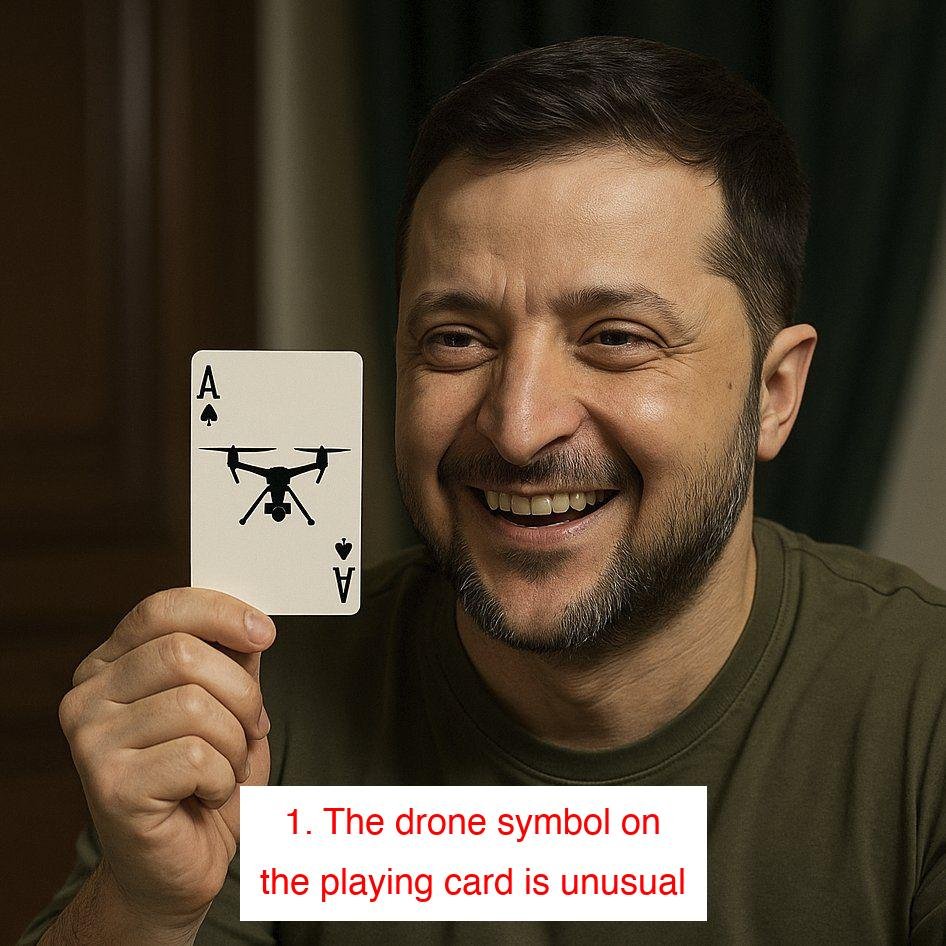

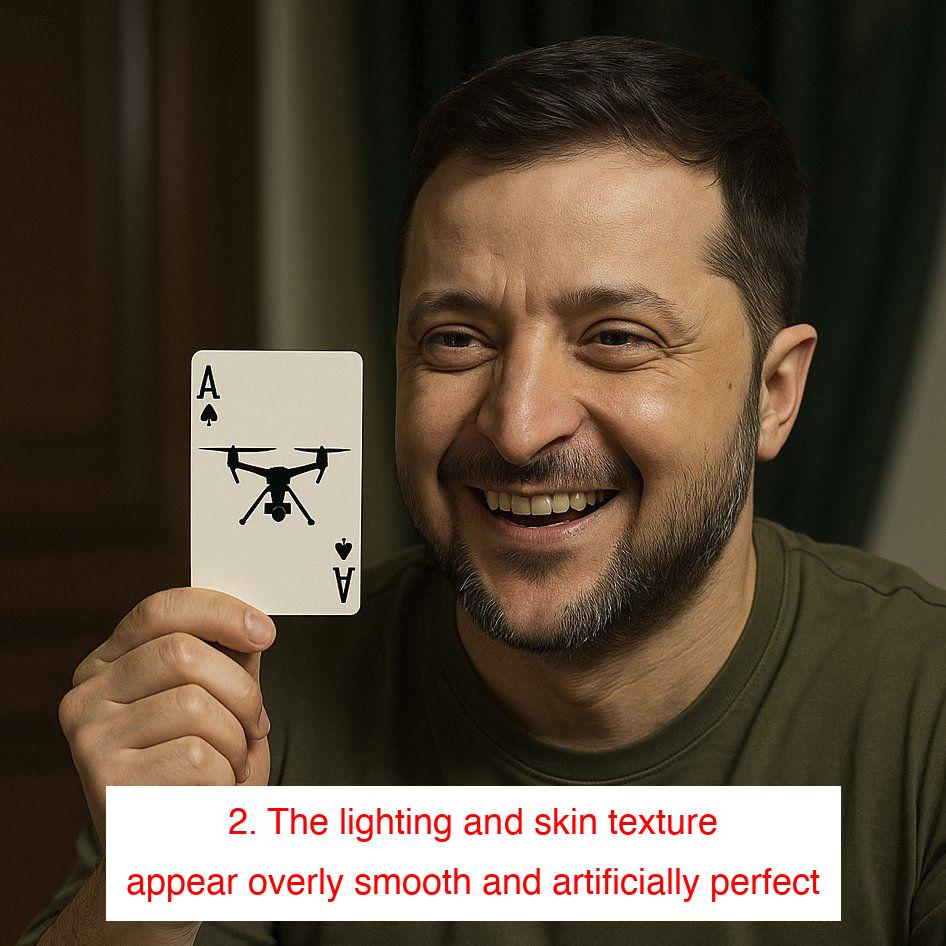

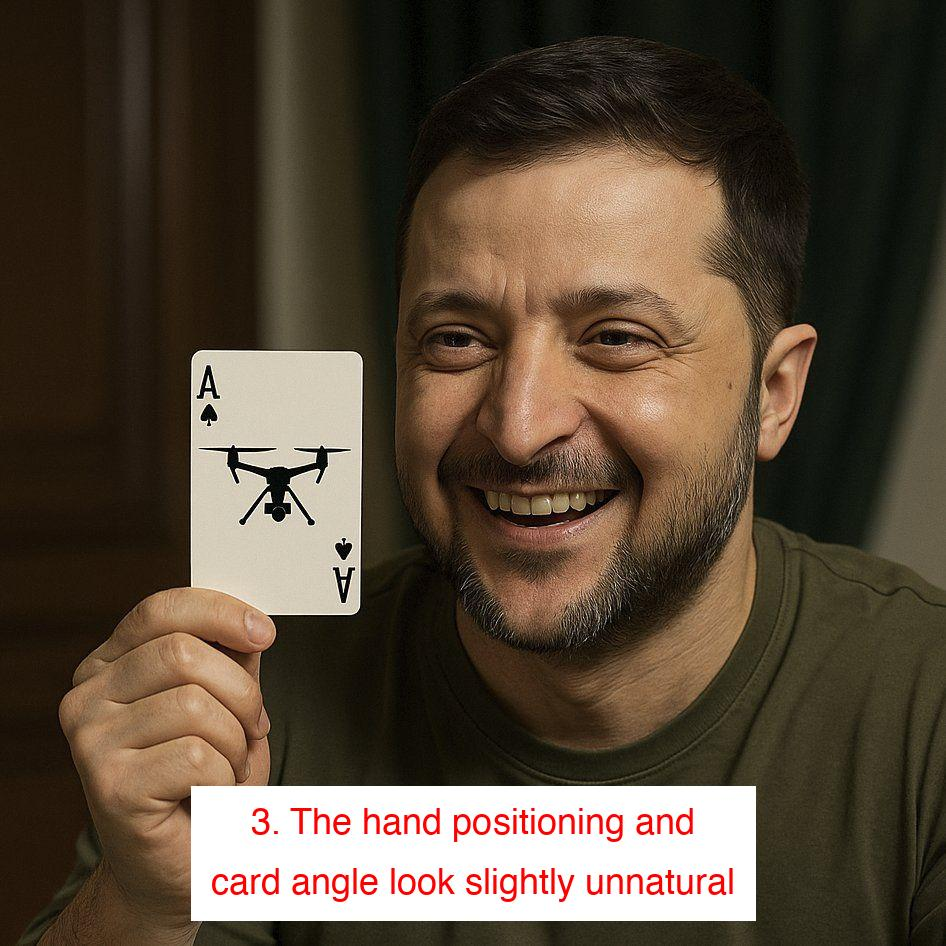

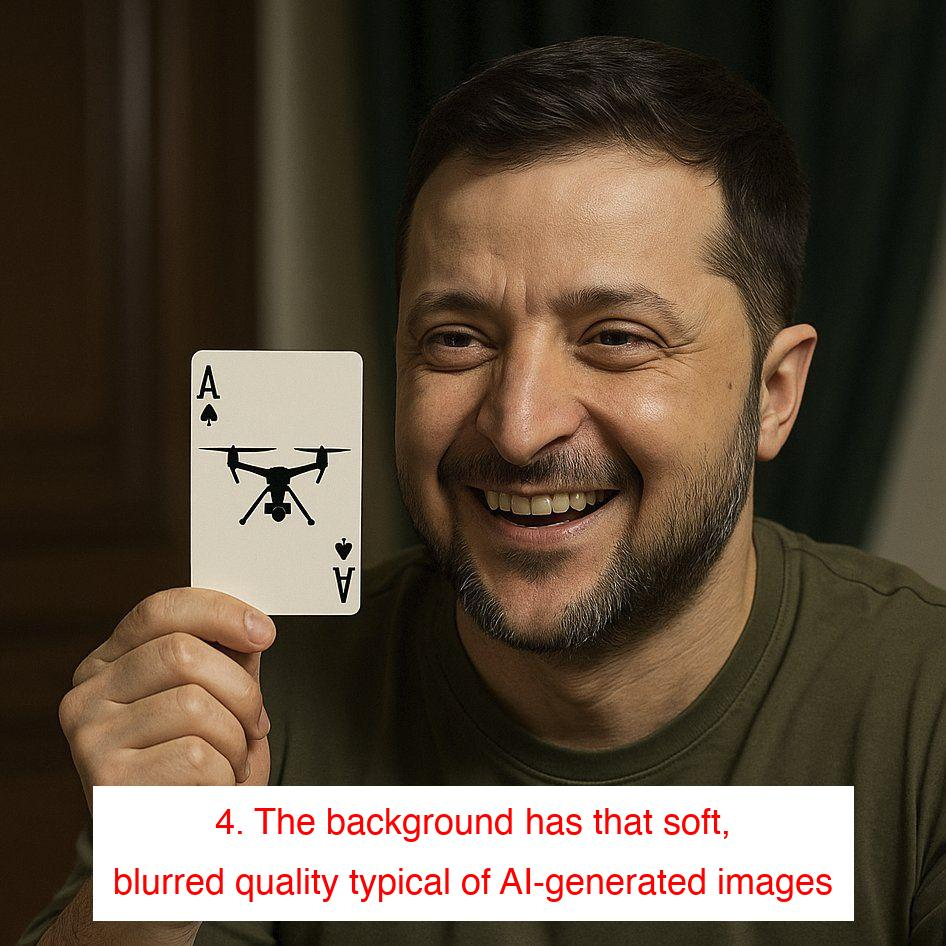

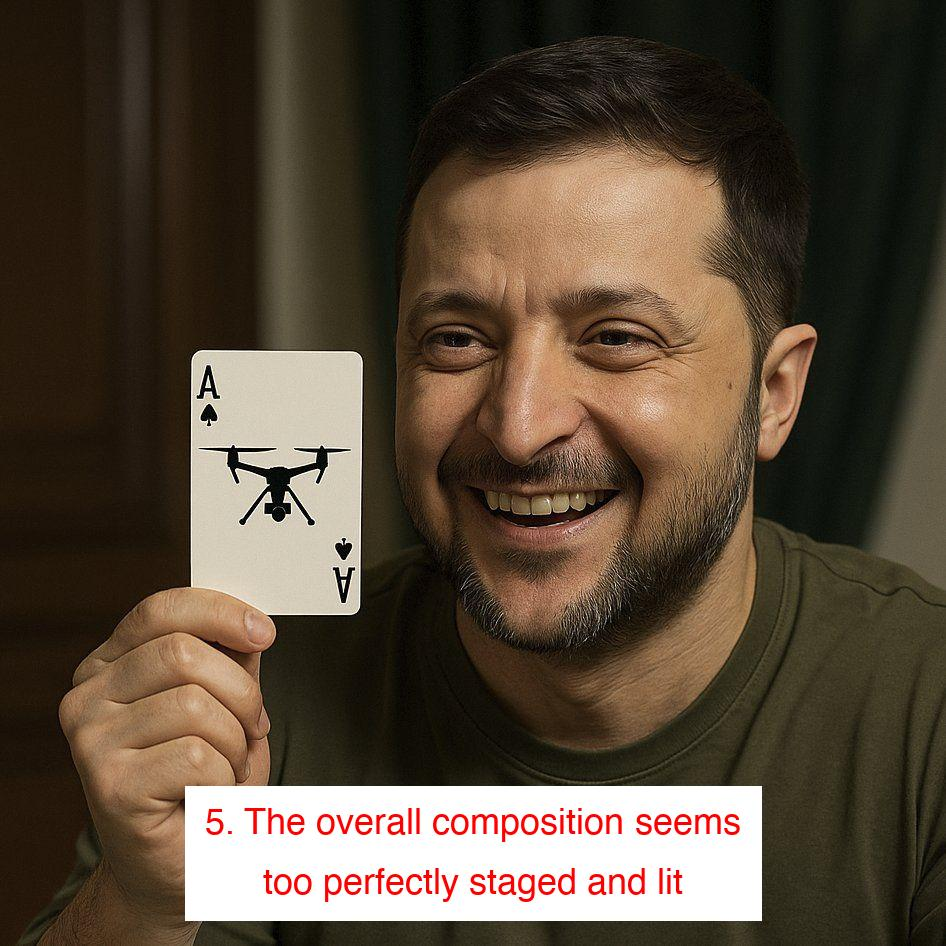

In [70]:
from PIL import Image, ImageDraw, ImageFont
import os

image_path = cropped_image

def add_caption_to_image(image_path, caption, output_filename):
    # Open the image
    img = Image.open(image_path)
    
    # Create a drawing object
    draw = ImageDraw.Draw(img)
    
    # Try to use a system font (adjust path for Mac)
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 36)
    except:
        font = ImageFont.load_default()
    
   # Split caption into two roughly equal parts at the nearest space
    words = caption.split()
    mid = len(words) // 2
    line1 = ' '.join(words[:mid])
    line2 = ' '.join(words[mid:])
    
    # Get text sizes for both lines
    bbox1 = draw.textbbox((0, 0), line1, font=font)
    bbox2 = draw.textbbox((0, 0), line2, font=font)
    text_width1 = bbox1[2] - bbox1[0]
    text_width2 = bbox2[2] - bbox2[0]
    
    # Calculate positions (centered horizontally, stacked vertically)
    x1 = (img.width - text_width1) // 2
    x2 = (img.width - text_width2) // 2
    y1 = img.height - 140  # First line
    y2 = img.height - 80   # Second line
    
 
    # Calculate total text height and maximum width
    padding = 20  # Padding around text
    line_spacing = 60  # Space between lines
    max_width = max(text_width1, text_width2)
    total_height = line_spacing + bbox1[3] - bbox1[1] + bbox2[3] - bbox2[1]
    
    # Calculate rectangle coordinates
    rect_left = (img.width - max_width) // 2 - padding
    rect_top = y1 - padding
    rect_right = rect_left + max_width + (padding * 2)
    rect_bottom = y2 + (bbox2[3] - bbox2[1]) + padding
    
    # Draw white background rectangle
    draw.rectangle([rect_left, rect_top, rect_right, rect_bottom], fill='white')


    # Draw both lines in red
    draw.text((x1, y1), line1, font=font, fill='red')
    draw.text((x2, y2), line2, font=font, fill='red')
    
    # Save the image
    output_path = f'images/captioned_{output_filename}.jpg'
    img.save(output_path)
    return output_path

# Create captioned versions for the selected arguments
captions = arguments  # Get the 5 arguments we want to use
captioned_images = []

for i, caption in enumerate(captions):
    output_path = add_caption_to_image(cropped_image, caption, f'version_{i+1}')
    captioned_images.append(output_path)
    
# Display all captioned images
for img_path in captioned_images:
    display(IPython.display.Image(img_path, width=500))

Animated GIF created successfully


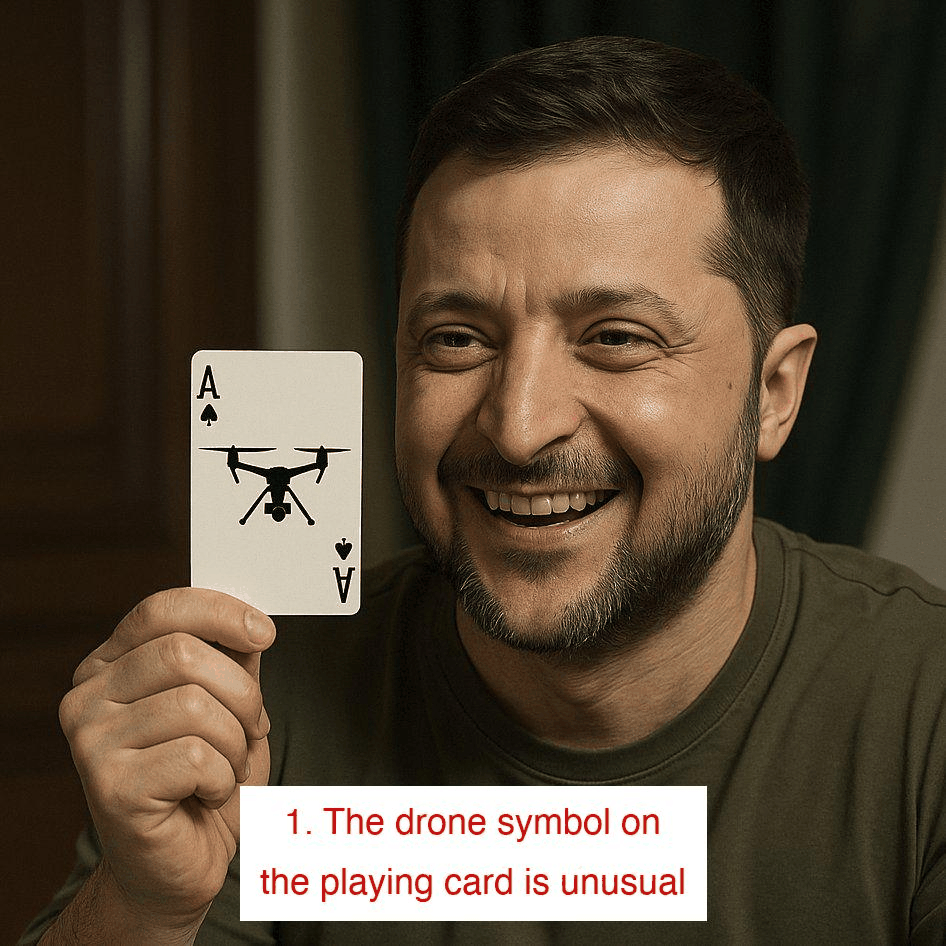

In [71]:
from PIL import Image
import os

def create_animated_gif(image_paths, output_path, duration=4000):
    """
    Create an animated GIF from a list of image paths
    duration: time in milliseconds between frames
    """
    # Open all images
    images = [Image.open(path) for path in captioned_images]
    
    # Save as animated GIF
    images[0].save(
        'images/animation.gif',
        save_all=True,
        append_images=images[1:],
        duration=duration,
        loop=0
    )
    print("Animated GIF created successfully")

# Create the animated GIF from the previously generated captioned images
create_animated_gif(captioned_images, 'images/animation.gif')

# Display the animated GIF
IPython.display.Image('images/animation.gif')